In [124]:
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from pygdsm import GlobalSkyModel2016

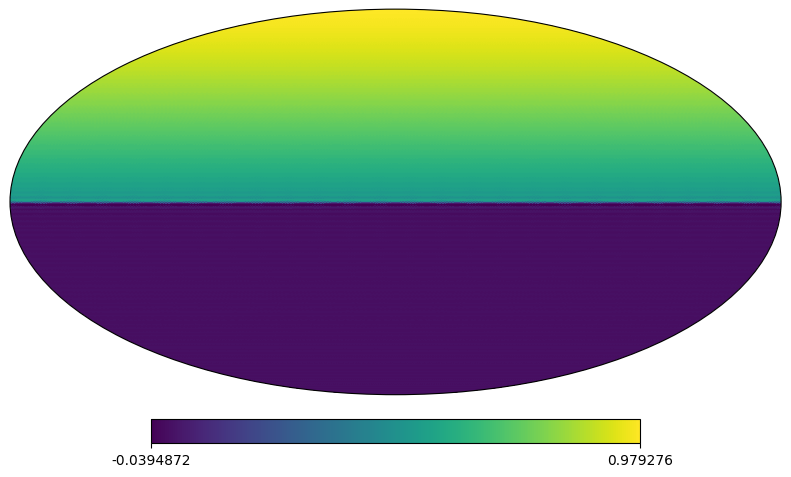

In [15]:
lmax = 200
nside = 128
freq = np.linspace(40, 120, 81)
nfreq = freq.size
beam_alm = np.zeros((nfreq, hp.Alm.getsize(lmax)))
beam = cro.Beam(beam_alm, lmax=lmax, frequencies=freq, coord="T")
beam[:, 0, 0] = np.sqrt(3) * (freq/freq[0])**2
beam[:, 1, 0] = 1 * (freq/freq[0])**2
beam.horizon_cut(nside=nside)
beam_map = beam.hp_map(nside)
hp.projview(beam_map[0]); plt.show()

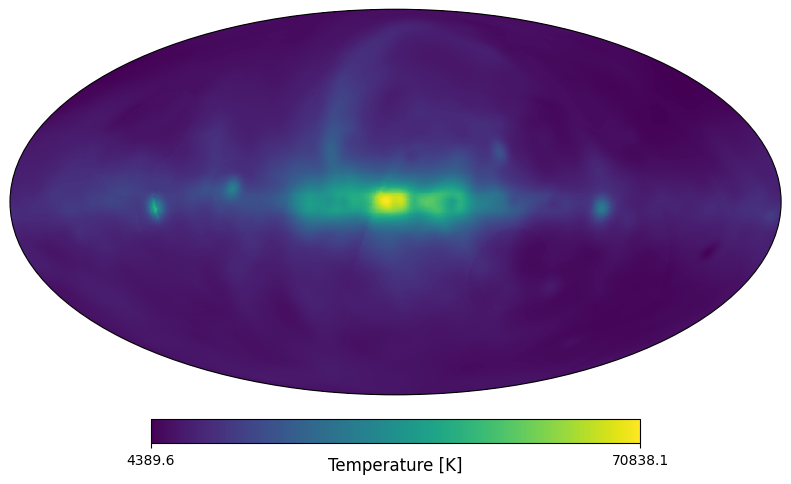

In [24]:
sky = cro.Sky.gsm(freq, lmax=lmax)
sky_map = sky.hp_map(nside)
hp.projview(sky_map[0], unit="Temperature [K]"); plt.show()

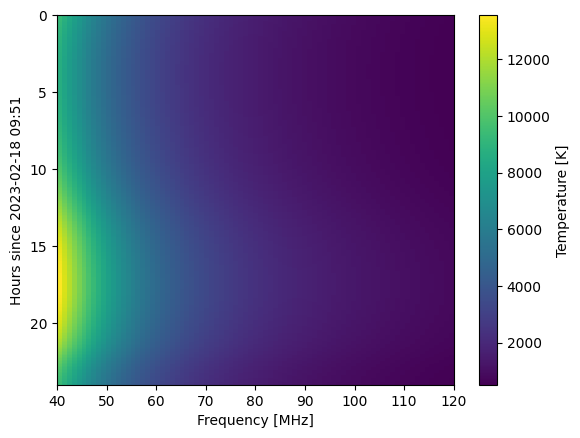

In [171]:
lat = 37.873199
lon = -122.257063
location = (lon, lat)
times = cro.simulator.time_array(t_start="2023-02-18 09:51", t_end="2023-02-19 09:51", N_times=250)
sim_kwargs = {"lmax": lmax, "frequencies": freq, "world": "earth", "location": location, "times": times}
sim = cro.Simulator(beam, sky, **sim_kwargs)
sim.run(dpss=False)
sim.plot()

In [55]:
monopole = sim.waterfall.mean(axis=0)
d = sim.waterfall - monopole
cov = d.T @ d
u, s, vt = np.linalg.svd(cov)

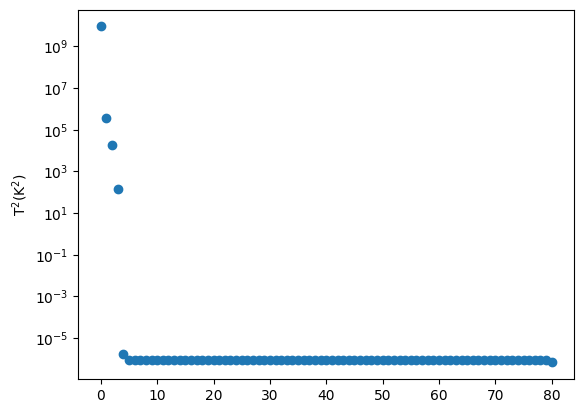

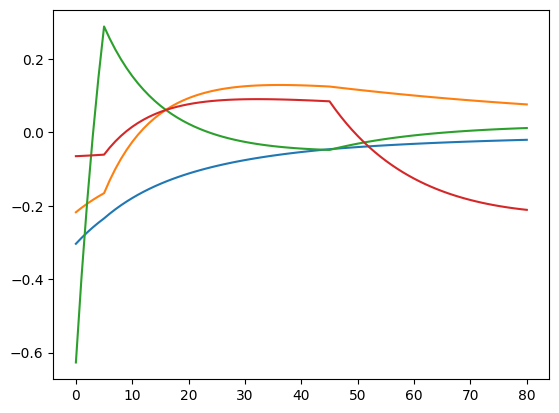

In [72]:
plt.figure()
plt.plot(s, marker="o", ls="")
plt.yscale("log")
plt.ylabel(r"$\rm{T}^2 \left(\rm{K}^2\right) $")
plt.show()

plt.figure()
plt.plot(vt[:4].T)
plt.show()

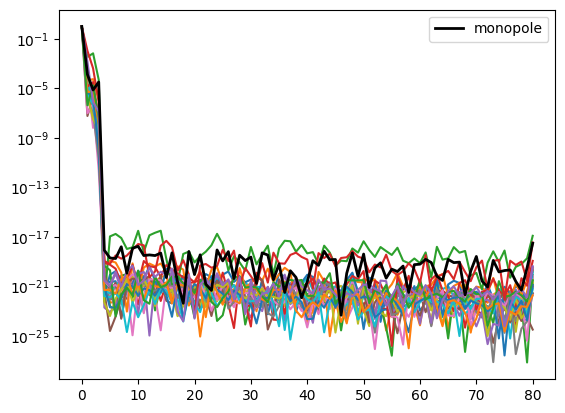

In [164]:
v = vt.T
fg_proj = (d @ v)**2
fg_proj /= np.sum(fg_proj, axis=1, keepdims=True)
mono_proj = (monopole @ v)**2
mono_proj /= np.sum(mono_proj)
plt.figure()
plt.plot(fg_proj[::10].T)
plt.plot(mono_proj, lw=2, c="k", label="monopole")
plt.legend()
plt.yscale("log")
plt.show()

What would the monopole curve in the above picture have to look like for us to conclude there is a 21cm signal present? Need to model the allowed shapes of a foreground-only monopole.

1) Generative model from multipole spectra to monopole spectrum?
2) Model foregrounds as e.g. power law at each pixel (check De Oliveira Costa paper) and see what the allowed shapes are. How do we take into account beam chromaticity?

Power laws:

Assumption is that the sky is a power law at each pixel, i.e. at any pixel $i$ the following holds:

$$T_{\rm sky} (\nu, i) = T_{\rm sky} (\nu_0, i) \left(\frac{\nu}{\nu_0} \right)^{\beta_i} $$

Thus, if we have two maps, at frequencies $\nu_1$ and $\nu_2$, we can compute the spectral indices $\beta_i$ and generate the map at all frequencies:

$$ \log{\frac{T_{\rm sky} (\nu_2, i)}{T_{\rm sky} (\nu_1, i)}} = \beta_i \log{\frac{\nu_2}{\nu_1}} \\
\beta_i = \left. \log{\frac{T_{\rm sky} (\nu_2, i)}{T_{\rm sky} (\nu_1, i)}} \middle/ \log{\frac{\nu_2}{\nu_1}} \right.$$

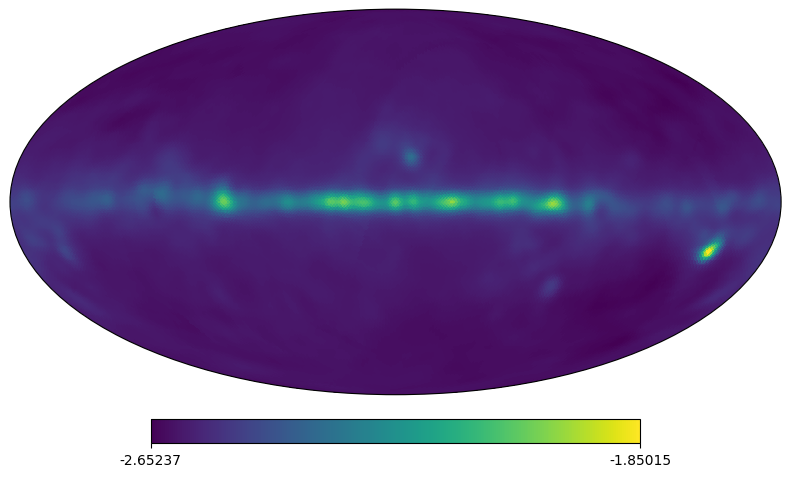

In [142]:
gsm = GlobalSkyModel2016(data_unit="TRJ", resolution="lo").generate((freq[0], freq[-1]))
betas = np.log(gsm[1] / gsm[0]) / np.log(freq[-1] / freq[0])
hp.projview(betas); plt.show()

In [155]:
# make the power law sky model
pl_healpix = cro.healpix.HealpixMap(gsm[None, 0] * (freq[:, None]/freq[0])**betas[None], frequencies=freq, coord="G")
pl_mono = pl_healpix.data.mean(axis=-1)

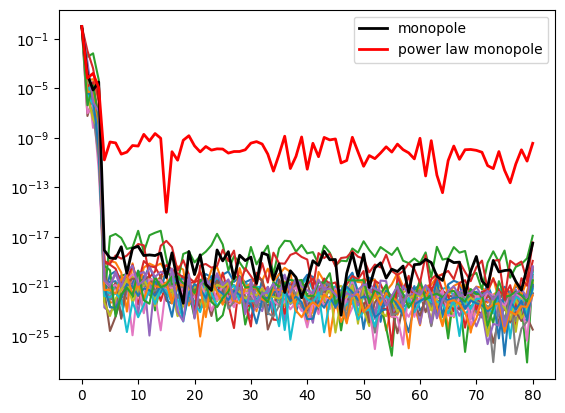

In [168]:
pl_proj = (pl_mono @ v)**2
pl_proj /= np.sum(pl_proj)
plt.figure()
plt.plot(fg_proj[::10].T)
plt.plot(mono_proj, lw=2, c="k", label="monopole")
plt.plot(pl_proj, lw=2, c="r", label="power law monopole")
plt.legend()
plt.yscale("log")
plt.show()

How do we do this with free parameters (at least for spectral index)?

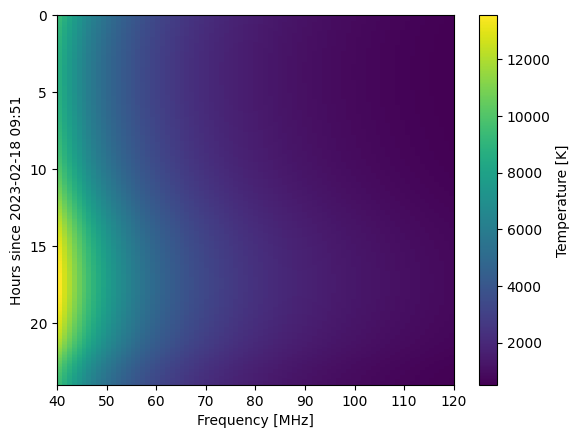

In [173]:
# put into simulator to get beam chromaticity?
pl_alm = cro.Alm.from_healpix(pl_healpix, lmax=lmax)
sim_pl = cro.Simulator(beam, pl_alm, **sim_kwargs)
sim_pl.run(dpss=False)
sim_pl.plot()

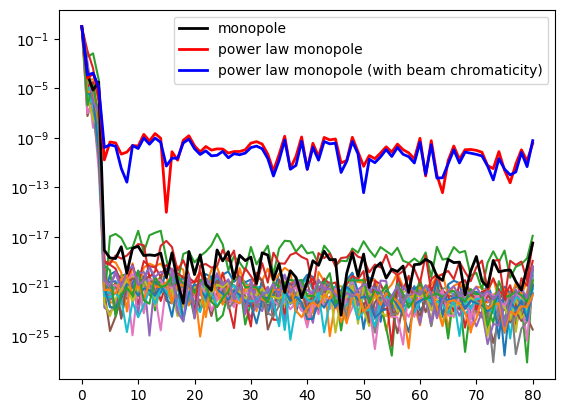

In [174]:
pl_sim_mono = sim_pl.waterfall.mean(axis=0)
pl_sim_proj = (pl_sim_mono @ v)**2
pl_sim_proj /= np.sum(pl_sim_proj)
plt.figure()
plt.plot(fg_proj[::10].T)
plt.plot(mono_proj, lw=2, c="k", label="monopole")
plt.plot(pl_proj, lw=2, c="r", label="power law monopole")
plt.plot(pl_sim_proj, lw=2, c="b", label="power law monopole (with beam chromaticity)")
plt.legend()
plt.yscale("log")
plt.show()